# Semantic Text Similarity

En este fichero se va a comparar el rendimiento diferentes modelos simples o de regresión de cara a la tarea de clasificación de similitud semántica entre frases en catalán. <sb>


In [ ]:
# Requisitos
from gensim.models import TfidfModel
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
import numpy as np
import spacy
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from scipy import spatial
from transformers import pipeline, AutoTokenizer, AutoModel
from scipy.special import logit
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn.functional as F

# Tipado
from typing import Tuple, List, Iterable, Any

Definir la base de datos y preprocesar:

In [7]:
# stopwords en Catalan
STOPWORDS_CA = {"a", "al", "el", "la", "els", "les", "de", "un", "una", "algun", "alguna", }
# Definir función de pre-procesado
def preprocess(sentence: str) -> List[str]:
    preprocessed = simple_preprocess(sentence) # Tokenización y normalización, lematización, minúsculas
    # Eliminar stopwords
    preprocessed = [token for token in preprocessed if token not in STOPWORDS_CA]
    return preprocessed

In [8]:
from datasets import load_dataset
# Text Similarity (STS) dataset (principal per la Pràctica 4)
train = load_dataset("projecte-aina/sts-ca", split="train")
test = load_dataset("projecte-aina/sts-ca", split="test")
val = load_dataset("projecte-aina/sts-ca", split="validation")
all_data = load_dataset("projecte-aina/sts-ca", split="all")
all_data

Dataset({
    features: ['id', 'sentence_1', 'sentence_2', 'label'],
    num_rows: 3073
})

In [9]:
def map_corpus(corpus: Any) -> List[Tuple[List[str], List[str], float]]:
    # Preprocesa las frases de cada elemento del corpus usando simple_preprocess (tokenización y normalización)
    sentences_1_preproc = [simple_preprocess(d["sentence_1"]) for d in corpus]  # Lista de listas: cada oración 1 preprocesada
    sentences_2_preproc = [simple_preprocess(d["sentence_2"]) for d in corpus]  # Lista de listas: cada oración 2 preprocesada
    scores = [d["label"] for d in corpus]  # Lista de puntuaciones de similitud
    # Une las oraciones preprocesadas y su puntuación en una lista de tuplas
    sentence_pairs = list(zip(sentences_1_preproc, sentences_2_preproc, scores))
    return sentence_pairs

# Aplica la función a los conjuntos de entrenamiento, test y validación
train_preproc = map_corpus(train)
test_preproc = map_corpus(test)
val_preproc = map_corpus(val)

Word Embedding **gensim** pre-entrenado: <sb>

In [10]:
from gensim.models.fasttext import FastTextKeyedVectors
#cargar como map:
wv_model = FastTextKeyedVectors.load('/home/taya/Desktop/cc.ca.gensim.bin', mmap='r')

Creamos modelos de dimensión reducida, mediante el truncamiento:

In [11]:
wv_model_50d = {
    word: wv_model[word][:50]
    for word in wv_model.index_to_key
}

wv_model_100d = {
    word: wv_model[word][:100]
    for word in wv_model.index_to_key
}
wv_model_150d = {
    word: wv_model[word][:150]
    for word in wv_model.index_to_key
}

Construcción del diccionario:

In [12]:
# Preprocesamiento de las oraciones y creación del diccionario
sentences_1_preproc = [simple_preprocess(d["sentence_1"]) for d in all_data] #lista de listas que son oraciones lematizadas
sentences_2_preproc = [simple_preprocess(d["sentence_2"]) for d in all_data]
scores = [d["label"] for d in all_data]
sentence_pairs = list(zip(sentences_1_preproc, sentences_2_preproc, scores))#lista de tuplas que son ([palabras or1], [pal or 2], score)
# Versión aplanada para poder entrenar el modelo
sentences_pairs_flattened = sentences_1_preproc + sentences_2_preproc #todas las oraciones juntas
diccionario = Dictionary(sentences_pairs_flattened) # diccionario donde cada palabra tiene un indice unico

Construcción de la matriz TF-IDF: <sb>

Sirve para dar más peso a las palabras importantes y menos peso a las comunes. <sb>
- TF (Term Frequency): Qué tan frecuente es una palabra en UN documento.
- IDF (Inverse Document Frequency): Qué tan rara es esa palabra en TODA la colección.<sb>

Así, el documnto se puede caracterizar por las palabras que contiene y diferenciar de otros por las palabras no comunes que contiene.

In [13]:
# Cálculo de los pesos TF-IDF para las oraciones pre-procesadas
corpus = [diccionario.doc2bow(sent) for sent in sentences_pairs_flattened]
"""
Por ejemplo, si sent es ['hola', 'mundo', 'hola'], el resultado de diccionario.doc2bow(sent) podría ser [(0, 2), (1, 1)], donde 0 es el índice de "hola" y 1 es el índice de "mundo", indicando que "hola" aparece 2 veces y "mundo" aparece 1 vez.
corpus = El resultado es una lista de representaciones de bolsa de palabras, donde cada elemento corresponde a una oración en el conjunto de datos.
"""
modelo_tfidf = TfidfModel(corpus) #transformar el corpus en una representación que refleja la importancia de las palabras en cada documento en relación con el corpus completo.

Aregación: <sb>

En esta parte, para poder obtener el embeding de una frase entera se van a promediar los embedings de cada palabra por la que está compuesta la frase, ponderando o no con los pesos TF-IDF.

In [14]:
def map_tf_idf(sentence_preproc: List[str], dictionary: Dictionary, tf_idf_model: TfidfModel, model = wv_model) -> Tuple[List[np.ndarray], List[float]]:
    """
    dada una oracion preprocesada, para cada palabra saca sus pesos TF-IDF y su vector en el embeding
    """
    bow = dictionary.doc2bow(sentence_preproc)#cuenta la frecuencia de cada palabra en la oracion
    tf_idf = tf_idf_model[bow] 
    vectors, weights = [], []
    for word_index, weight in tf_idf:
        word = dictionary.get(word_index)
        if word in model:
            vectors.append(model[word])
            weights.append(weight)
    return vectors, weights

def map_pairs(wv_model2, sentence_pairs: List[Tuple[str, str, float]],dictionary: Dictionary = None, tf_idf_model: TfidfModel = None,) -> List[Tuple[Tuple[np.ndarray, np.ndarray], float]]:
    """
    Mapea los tripletes de oraciones a listas de (x, y), (pares de vectores, score)
    :param sentence_pairs: lista de tuplas que son ([palabras or1], [palabras or2], score)
    :param dictionary: diccionario donde cada palabra tiene un indice unico
    :param tf_idf_model: objeto TfidfModel que da los pesos de las palabras (se puede indexar con un bag of words)
    :return: lista de ((vector1, vector2), similitud), donde vector1 y vector2 cambian en funcion de:
        si tf_idf_model is not None:
                para cada elemento de sentence_pairs devuelve el vector embeding promediado de manera ponderada por los pesos de la matriz TF-IDF de las palabras de las oraciones 1 y 2.
        si tf_idf_model is not None
            el promedio de los vectores de embeding de las palabras que componen cada una de las oraciones
    """
    # Mapeo de los pares de oraciones a pares de vectores
    pares_vectores = []
    for i, (sentence_1, sentence_2, similitud) in enumerate(sentence_pairs):
        sentence_1_preproc = preprocess(sentence_1) if isinstance(sentence_1, str) else sentence_1 # se procesa el texto antes de aplicar map_pairs entonces sentence_1 es una lista de tokens y ya nose vuelve a preprocesar
        sentence_2_preproc = preprocess(sentence_2) if isinstance(sentence_2, str) else sentence_2
        # Si usamos TF-IDF
        if tf_idf_model is not None:
            # Cálculo del promedio ponderado por TF-IDF de los word embeddings
            vectors1, weights1 = map_tf_idf(sentence_1_preproc, dictionary=dictionary, tf_idf_model=tf_idf_model,model =  wv_model2, )
            vectors2, weights2 = map_tf_idf(sentence_2_preproc, dictionary=dictionary, tf_idf_model=tf_idf_model, model = wv_model2 )
            vector1 = np.average(vectors1, weights=weights1, axis=0, ) #Esta función calcula el promedio de un conjunto de valores. Si se proporciona un argumento weights, el promedio se calcula de manera ponderada, lo que significa que cada valor contribuye al promedio de acuerdo con su peso correspondiente.
            vector2 = np.average(vectors2, weights=weights2, axis=0, )
        else:
            # Cálculo del promedio de los word embeddings
            vectors1 = [wv_model2[word] for word in sentence_1_preproc if word in wv_model2]
            vectors2 = [wv_model2[word] for word in sentence_2_preproc if word in wv_model2]
            vector1 = np.mean(vectors1, axis=0)
            vector2 = np.mean(vectors2, axis=0)
        # Añadir a la lista
        pares_vectores.append(((vector1, vector2), similitud))
    return pares_vectores

In [15]:
mapped_no_tfidf = map_pairs(wv_model, train_preproc, tf_idf_model=None, dictionary=diccionario, )
mapped_train_tfidf = map_pairs(wv_model,train_preproc, tf_idf_model=modelo_tfidf, dictionary=diccionario, )

mapped_val_no_tfidf = map_pairs(wv_model,val_preproc, tf_idf_model=None, dictionary=diccionario, )
mapped_val_tfidf = map_pairs(wv_model,val_preproc, tf_idf_model=modelo_tfidf, dictionary=diccionario, )

mapped_train_tfidf[0]# Imprimir los pares de vectores y la puntuación de similitud asociada

((array([-7.22131877e-03, -4.88683421e-03,  2.71017708e-02,  2.32332627e-02,
         -9.60097482e-03, -3.16095435e-03,  2.90225599e-02, -1.75413820e-02,
          2.93095319e-02, -1.60574403e-02, -6.04936805e-03,  1.49908545e-02,
          1.00934507e-02,  1.84449753e-02,  2.16156266e-02,  2.13238810e-02,
          8.69774586e-03,  6.13958934e-02,  2.18719114e-02,  1.01426407e-02,
          1.16837708e-02,  3.24588305e-03, -1.32856906e-02,  5.77104877e-02,
          1.54627187e-02,  2.13443526e-02, -3.82471218e-02,  6.23983637e-03,
          7.31161386e-04,  8.99225741e-03, -4.87626204e-03,  1.08773269e-02,
          1.30313145e-02, -3.86450925e-03,  7.23370200e-03, -1.75266524e-02,
         -9.09778208e-03,  4.43412138e-02, -4.31998409e-04,  6.25044253e-04,
         -1.13920750e-02, -1.82465011e-02, -8.11444328e-03, -8.18518457e-03,
         -3.54176235e-03, -1.60820262e-01,  7.74505797e-03,  9.80261699e-03,
          8.53058034e-03, -1.23878019e-02,  1.24134202e-02, -2.39070017e-03,

De dimensión reducida: <sb>

- sí usando pesos TF-IDF

In [16]:
mapped_50 = map_pairs(wv_model_50d, train_preproc, tf_idf_model=modelo_tfidf, dictionary=diccionario, )
mapped_100 = map_pairs(wv_model_100d, train_preproc, tf_idf_model=modelo_tfidf, dictionary=diccionario, )
mapped_150 = map_pairs(wv_model_150d, train_preproc, tf_idf_model=modelo_tfidf, dictionary=diccionario, )


mapped_val_50 = map_pairs(wv_model_50d, val_preproc, tf_idf_model=modelo_tfidf, dictionary=diccionario, )
mapped_val_100 = map_pairs(wv_model_100d, val_preproc, tf_idf_model=modelo_tfidf, dictionary=diccionario, )
mapped_val_150 = map_pairs(wv_model_150d, val_preproc, tf_idf_model=modelo_tfidf, dictionary=diccionario, )

In [17]:
# Imprimir las dimensiones de los vectores resultantes
print(mapped_no_tfidf[0][0][0].shape)
print(mapped_train_tfidf[0][0][0].shape)
print(mapped_50[0][0][0].shape)
print(mapped_100[0][0][0].shape)
print(mapped_150[0][0][0].shape)

(300,)
(300,)
(50,)
(100,)
(150,)


Definición de diferentes modelos:

In [ ]:
# Definir el Modelo

def build_and_compile_model(hidden_size: int = 128, embedding_size: int = 300, learning_rate: float = 0.001) -> tf.keras.Model:
    """
    Esto crea una red neuronal de manera que al entrenarla las distancias coseno cuadren con la etiqueta real
    hidden_size: Tamaño de capas ocultas (no se usa en este código)
    embedding_size: Dimensión de los vectores de entrada (300)
    learning_rate: Tasa de aprendizaje para el optimizador
    """
    # Capa de entrada para los pares de vectores
    input_1 = tf.keras.Input(shape=(embedding_size,)) #los pares de vectores a comparar
    input_2 = tf.keras.Input(shape=(embedding_size,))

    # Capa oculta, con funcion de activacion lineal, tiene como objetivo proyectar los vectores de entrada en un nuevo espacio.
    """
    La capa oculta (en este caso, la capa densa) tiene pesos que se ajustan durante el entrenamiento.
    Estos pesos son los que transforman los vectores de entrada en los vectores proyectados
    """
    first_projection = tf.keras.layers.Dense(
        embedding_size,
        # activation='tanh',
        kernel_initializer=tf.keras.initializers.Identity(),# inicializa los pesos de la capa como una matriz identidad
        bias_initializer=tf.keras.initializers.Zeros(),
    )
    #aplica la capa de proyeccion a los dos vectores de entrada
    projected_1 = first_projection(input_1)
    projected_2 = first_projection(input_2)

    normalize = tf.keras.layers.Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1))
    projected_1 = normalize(projected_1)
    projected_2 = normalize(projected_2)
    output = tf.keras.layers.Lambda(lambda tensors: 2.5 * (1.0 + tf.reduce_sum(tensors[0] * tensors[1], axis=1)))([projected_1, projected_2])
    # Definir el modelo con las capas de entrada y salida
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output) #Durante el entrenamiento, Keras ajusta los pesos de la capa oculta para minimizar la función de pérdida definida (en este caso, el error absoluto medio).

    # Compilar el modelo
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(learning_rate))

    return model

**build_and_compile_model**: Proyección lineal + Similitud Coseno 

Arquitectura:

- Aplica una capa densa compartida (misma proyección) a cada vector por separado. Inicialmente es una matriz identidad.
- Los normaliza a magnitud 1.
- Calcula la similitud coseno como cos(θ) = dot(product).
- La salida es 2.5 * (1 + similitud_coseno), lo cual transforma el rango [-1, 1] a [0, 5].
- Se entrena con MAE (Mean Absolute Error).

Objetivo:
- Aprender una proyección donde la similitud coseno refleje la puntuación deseada (por ejemplo, cuán similares son dos textos o frases).



In [19]:
def build_model_aggregated(embedding_dim: int, hidden_size: int = 128, dropout_rate: float = 0.3) -> tf.keras.Model:
    input_1 = tf.keras.Input(shape=(embedding_dim,), name="input_vector_1")
    input_2 = tf.keras.Input(shape=(embedding_dim,), name="input_vector_2")
    concatenated = tf.keras.layers.Concatenate(axis=-1)([input_1, input_2])
    x = tf.keras.layers.BatchNormalization()(concatenated)
    x = tf.keras.layers.Dense(hidden_size, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    output = tf.keras.layers.Dense(1)(x) # Activació lineal per a regressió
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

#model_agg.fit([X1_train, X2_train], Y_train, epochs=..., batch_size=...)

Modelo **build_model_aggregated**: Concatenación + Red Neuronal Densa
Arquitectura:
- Toma dos vectores de entrada (input_vector_1, input_vector_2).
- Los concatena (Concatenate), por lo que la dimensión del vector combinado es el doble del embedding_dim.
- Aplica:
    - BatchNormalization
    - Dense con ReLU
    - Otro BatchNormalization
    - Dropout
    - Una capa de salida densa sin activación (regresión lineal).
    - Se entrena con MSE (Mean Squared Error).

Objetivo:
- Aprender una función no lineal entre los vectores concatenados y la puntuación objetivo (p. ej., similitud STS, afinidad, etc.).



In [20]:

def build_and_compile_model2(embedding_size: int = 300, learning_rate: float = 0.001) -> tf.keras.Model:
    # Input layer
    input_1 = tf.keras.Input(shape=(embedding_size,), name="input_vector_1")
    input_2 = tf.keras.Input(shape=(embedding_size,), name="input_vector_2")

    # hidden layer
    first_projection_layer = tf.keras.layers.Dense(
        embedding_size,
        activation='tanh',
        kernel_initializer=tf.keras.initializers.Identity(),
        bias_initializer=tf.keras.initializers.Zeros(),
        name="projection_layer"
    )
    dropout = tf.keras.layers.Dropout(0.3, name="projection_dropout")
    projected_1_dense = dropout(first_projection_layer(input_1))
    projected_2_dense = dropout(first_projection_layer(input_2))

    # Normalize the projected vectors using Lambda layers
    normalized_1 = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1), name="normalize_1"
    )(projected_1_dense)
    normalized_2 = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1), name="normalize_2"
    )(projected_2_dense)

    # Compute the custom similarity score using a Lambda layer
    similarity_sum = tf.keras.layers.Lambda(
        lambda x: tf.reduce_sum(x[0] * x[1], axis=1, keepdims=True), name="similarity_sum"
    )([normalized_1, normalized_2])

    output = tf.keras.layers.Lambda(
        lambda x: 0.5 * (1.0 + x), name="output_scaling" #cambiar 0.5 por 2.5 para que este entre 0 y 5 
    )(similarity_sum)

    # Definir el modelo con las capas de entrada y salida
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output, name="similarity_model")

    # Compilar el modelo
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    )

    return model


Modelo **build_and_compile_model2**.

Deferencias clave con build_and_compile_model: 

| Aspecto                         | build_and_compile_model                  | `build_and_compile_model2`                              |
| ------------------------------- | ----------------------------------------- | ------------------------------------------------------ |
| **Activación en la proyección** | Ninguna (lineal)                          | `tanh` (no lineal)                                     |
| **Regularización**              | No hay                                    | Sí, con `Dropout`                                      |
| **Normalización**               | Directamente con `tf.linalg.l2_normalize` | Igual, pero encapsulada en `Lambda` layers con nombres |
| **Similitud coseno**            | `2.5 * (1.0 + coseno)`                    | `0.5 * (1.0 + coseno)`                                 |
| **Escalado de salida**          | Rango `[0, 5]`                            | Rango `[0, 1]`                                         |
| **Perdida**                     | `mean_absolute_error`                     | `mean_squared_error`                                   |


# Training y evaluación:

In [21]:
# Definir constantes de entrenamiento
batch_size: int = 64
num_epochs: int = 64

In [22]:
def evaluate_model(
    model,
    X1_test: np.ndarray,
    X2_test: np.ndarray,
    Y_test: np.ndarray,
    name: str = ""
) -> dict:
    """
    Evalúa un modelo de similitud semántica sobre un conjunto de test y muestra varias métricas.

    Args:
        model: Modelo entrenado (por ejemplo, un modelo de Keras).
        X1_test: Array de vectores de entrada 1 (frase 1).
        X2_test: Array de vectores de entrada 2 (frase 2).
        Y_test: Array de etiquetas verdaderas (similitud real).
        name: Nombre del modelo (opcional, para mostrar en los resultados).

    Returns:
        Diccionario con las métricas calculadas: MSE, RMSE, MAE, Pearson y Spearman.
    """
    # Realiza la predicción del modelo
    y_pred = model.predict([X1_test, X2_test]).squeeze()
    y_true = Y_test.squeeze()

    # Calcula las métricas de evaluación
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    pearson, _ = pearsonr(y_true, y_pred)
    spearman, _ = spearmanr(y_true, y_pred)

    # Muestra los resultados por pantalla
    print(f"\n🔎 Resultados para el modelo '{name}':")
    print(f"MSE:      {mse:.4f}")
    print(f"RMSE:     {rmse:.4f}")
    print(f"MAE:      {mae:.4f}")
    print(f"Pearson:  {pearson:.4f}")
    print(f"Spearman: {spearman:.4f}")

    # Devuelve las métricas en un diccionario
    return {
        "name": name,
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "pearson": pearson,
        "spearman": spearman
    }


Obtener Train y Validation:

In [23]:
def pair_list_to_x_y(pair_list: List[Tuple[Tuple[np.ndarray, np.ndarray], int]]) -> Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]:
    """
    Obtiene las matrices X_1 (N x d) , X_2 (N x d), e Y (n) a partir de listas de parejas de vectores de oraciones - Listas de (d, d, 1)
    :param pair_list: lista que devuelve map_pairs(), lista de ((vector1, vector2), similitud), sonde vector1 y 2 son vectores agregados
    :return:
    transforma una lista de pares de vectores y puntuaciones en el formato adecuado para alimentar a un modelo de aprendizaje automático.
    """
    _x, _y = zip(*pair_list) #_x: lista de tuplas (embedding_1, embedding_2), _y: lista de etiquetas
    _x_1, _x_2 = zip(*_x)#_x_1: todos los embedding_1,  _x_2: todos los embedding_2
    return (np.array(_x_1), np.array(_x_2)), np.array(_y, dtype=np.float32, ) / 5.0

In [24]:
# Obtener las listas de train y test USANDO TF-IDF
x_train, y_train = pair_list_to_x_y(mapped_train_tfidf)
x_val, y_val = pair_list_to_x_y(mapped_val_tfidf)


# Obtener las listas de train y test SIN USAR TF-IDF
x_train_normal, y_train_normal = pair_list_to_x_y(mapped_no_tfidf)
x_val_normal, y_val_normal = pair_list_to_x_y(mapped_val_no_tfidf)

In [25]:
#De dimension reducida CON TF-IDF
x_train_50, y_train_50 = pair_list_to_x_y(mapped_50)
x_val_50, y_val_50 = pair_list_to_x_y(mapped_val_50)

x_train_100, y_train_100 = pair_list_to_x_y(mapped_100)
x_val_100, y_val_100 = pair_list_to_x_y(mapped_val_100)

x_train_150, y_train_150 = pair_list_to_x_y(mapped_150)
x_val_150, y_val_150 = pair_list_to_x_y(mapped_val_150)

In [26]:
# Preparar los conjuntos en forma de tensor
#Con TF-IDF
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)


#Sin TF-IDF
train_dataset_normal = tf.data.Dataset.from_tensor_slices((x_train_normal, y_train_normal))
train_dataset_normal = train_dataset_normal.shuffle(buffer_size=len(x_train_normal)).batch(batch_size)

val_dataset_normal = tf.data.Dataset.from_tensor_slices((x_val_normal, y_val_normal))
val_dataset_normal = val_dataset_normal.batch(batch_size)

2025-06-06 21:40:54.666095: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [27]:
#Dimensión 50
train_dataset_50 = tf.data.Dataset.from_tensor_slices((x_train_50, y_train_50))
train_dataset_50 = train_dataset_50.shuffle(buffer_size=len(x_train_50)).batch(batch_size)

val_dataset_50 = tf.data.Dataset.from_tensor_slices((x_val_50, y_val_50))
val_dataset_50 = val_dataset_50.batch(batch_size)

#Dimensión 100
train_dataset_100 = tf.data.Dataset.from_tensor_slices((x_train_100, y_train_100))
train_dataset_100 = train_dataset_100.shuffle(buffer_size=len(x_train_100)).batch(batch_size)

val_dataset_100 = tf.data.Dataset.from_tensor_slices((x_val_100, y_val_100))
val_dataset_100 = val_dataset_100.batch(batch_size)


#Dimensión 150
train_dataset_150 = tf.data.Dataset.from_tensor_slices((x_train_150, y_train_150))
train_dataset_150 = train_dataset_150.shuffle(buffer_size=len(x_train_150)).batch(batch_size)

val_dataset_150 = tf.data.Dataset.from_tensor_slices((x_val_150, y_val_150))
val_dataset_150 = val_dataset_150.batch(batch_size)


## Modelo COS:

Podemos no entrenar ningún modelo si sólo utilizamos COS similarity. El rendiminto dependerá completamente del Word Embedding.

In [28]:
y_pred_baseline = []
y_pred_normal = []
y_pred_50 = []
y_pred_100 = []
y_pred_150 = []
for j in range(len(mapped_val_tfidf)):
    i = mapped_val_tfidf[j]
    v1= i[0][0] 
    v2 = i[0][1]
    d = 1.0 - spatial.distance.cosine(v1, v2)
    y_pred_baseline.append(d)

    k = mapped_val_no_tfidf[j]
    v1 = k[0][0]
    v2 = k[0][1] 
    d = 1.0 - spatial.distance.cosine(v1, v2)
    y_pred_normal.append(d)

    m = mapped_val_50[j]
    v1 = m[0][0] 
    v2 = m[0][1]
    d = 1.0 - spatial.distance.cosine(v1, v2)
    y_pred_50.append(d)

    l = mapped_val_100[j]
    v1 = l[0][0]
    v2 = l[0][1] 
    d = 1.0 - spatial.distance.cosine(v1, v2)
    y_pred_100.append(d)

    e = mapped_val_150[j]
    v1 = e[0][0]
    v2 = e[0][1] 
    d = 1.0 - spatial.distance.cosine(v1, v2)
    y_pred_150.append(d)

# Calcular la correlación de Pearson entre las predicciones y los datos de prueba
correlation, _ = pearsonr(np.array(y_pred_baseline), y_val.flatten())
correlation_normal, _ = pearsonr(np.array(y_pred_normal), y_val_normal.flatten())
correlation_50, _ = pearsonr(np.array(y_pred_50), y_val_50.flatten())
correlation_100, _ = pearsonr(np.array(y_pred_100), y_val_100.flatten())
correlation_150, _ = pearsonr(np.array(y_pred_150), y_val_150.flatten())

# Imprimir el coeficiente de correlación de Pearson
print(f"Usando media clásica la correlación de Pearson es: {correlation}")
print(f"Usando media ponderada con TF-IDF la correlación de Pearson es: {correlation_normal}")
print(f"Usando media ponderada con TF-IDF y dimensión 50, la correlación de Pearson es: {correlation_50}")
print(f"Usando media ponderada con TF-IDF y dimensión 100, la correlación de Pearson es: {correlation_100}")
print(f"Usando media ponderada con TF-IDF y dimensión 150, la correlación de Pearson es: {correlation_150}")


Usando media clásica la correlación de Pearson es: 0.4023026679065351
Usando media ponderada con TF-IDF la correlación de Pearson es: 0.24358562692308788
Usando media ponderada con TF-IDF y dimensión 50, la correlación de Pearson es: 0.3632097710213902
Usando media ponderada con TF-IDF y dimensión 100, la correlación de Pearson es: 0.38166246524470904
Usando media ponderada con TF-IDF y dimensión 150, la correlación de Pearson es: 0.39754565403044134


- Vemos que, en este caso, la ponderación con los pesos TF-IDF empeora considerablemente el rendimiento. Si dos frases tienen pocas o ninguna palabra en común, el coseno será bajo, aunque el significado sea parecido.
- La reducción de la dimensión también afecta negativamente al modelo. Suponemos que es debido a la pérdida considerable de información.
- Nos gustaría poder modificar los pesos durante el cálculo de la distancia coseno.

# Modelos de Regresión 1, prueba del embeding pre-entrenado:

**Sin distancia coseno**, modelo simple de regresión.

In [29]:
#Con TF-IDF
model_no_cos = build_model_aggregated(embedding_dim=300)
model_no_cos.fit([x_train], y_train, epochs=num_epochs, batch_size=batch_size)

Epoch 1/64


/home/taya/Desktop/myenv/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_vector_1', 'input_vector_2']
Received: inputs=(('Tensor(shape=(None, 300))', 'Tensor(shape=(None, 300))'),)
  warnings.warn(msg)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.5055 - mae: 1.2171 - root_mean_squared_error: 1.5797
Epoch 2/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4504 - mae: 0.9192 - root_mean_squared_error: 1.2035
Epoch 3/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9373 - mae: 0.7495 - root_mean_squared_error: 0.9679
Epoch 4/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7207 - mae: 0.6446 - root_mean_squared_error: 0.8488
Epoch 5/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5769 - mae: 0.5778 - root_mean_squared_error: 0.7591
Epoch 6/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4608 - mae: 0.5098 - root_mean_squared_error: 0.6782
Epoch 7/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3841 - mae: 0.4838 - root_mean_squared_error: 0.6198
Epoch 8/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3248 - mae: 0.4401 - root_mean_squared_error: 0.5695
Epoch 9/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2571 - mae: 0.3875 - root_mean_squared_error: 0

In [30]:
X1, X2 = x_val
D_agragated_tfidf = evaluate_model(model_no_cos, X1, X2, y_val, name="Linealmodel no cos()")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

🔎 Resultados para el modelo 'Linealmodel no cos()':
MSE:      0.0308
RMSE:     0.1756
MAE:      0.1344
Pearson:  0.2468
Spearman: 0.2546


In [31]:
#Sin TF-IDF
model_no_cos_no_tfidf = build_model_aggregated(embedding_dim=300)
model_no_cos.fit([x_train_normal], y_train_normal, epochs=num_epochs, batch_size=batch_size)


Epoch 1/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 - mae: 0.1002 - root_mean_squared_error: 0.1301
Epoch 2/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141 - mae: 0.0925 - root_mean_squared_error: 0.1185
Epoch 3/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - mae: 0.0947 - root_mean_squared_error: 0.1213
Epoch 4/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - mae: 0.0952 - root_mean_squared_error: 0.1236
Epoch 5/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - mae: 0.0938 - root_mean_squared_error: 0.1210
Epoch 6/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136 - mae: 0.0896 - root_mean_squared_error: 0.1165
Epoch 7/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - mae: 0.0892 - root_mean_squared_error: 0.1123
Epoch 8/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - mae: 0.0861 - root_mean_squared_error: 0.1116
Epoch 9/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - mae: 0.0854 - root_mean_squar

In [32]:
X1, X2 = x_val_normal
D_agragated_no_tfidf = evaluate_model(model_no_cos, X1, X2, y_val_normal, name="Linealmodel no cos()")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

🔎 Resultados para el modelo 'Linealmodel no cos()':
MSE:      0.0314
RMSE:     0.1771
MAE:      0.1336
Pearson:  0.2577
Spearman: 0.2713


- Este modelo no tiene mucho sentido ya que no incorpora la distancia coseno en el etrenamiento.
- TF-IDF no mejora el rendimiento.

**Modelo con coseno y activación lineal:**

In [33]:
model_lin = build_and_compile_model()
model_lin.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

Epoch 1/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.9945 - val_loss: 3.7056
Epoch 2/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6515 - val_loss: 3.6114
Epoch 3/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5301 - val_loss: 3.5616
Epoch 4/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4431 - val_loss: 3.5285
Epoch 5/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3736 - val_loss: 3.5051
Epoch 6/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3150 - val_loss: 3.4873
Epoch 7/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2658 - val_loss: 3.4731
Epoch 8/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2222 - val_loss: 3.4616
Epoch 9/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1845 - val_loss: 3.4523
Epoch 10/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1504 - val_loss: 3.4442
Epoch 11/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1203 - val_loss: 3.4382
Epoch 12/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0945 - val_lo

In [34]:
X1, X2 = x_val
D_lin_tfidf = evaluate_model(model_lin, X1, X2, y_val)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

🔎 Resultados para el modelo '':
MSE:      12.1662
RMSE:     3.4880
MAE:      3.3310
Pearson:  0.2451
Spearman: 0.2986


In [35]:
model_lin_no_tfidf = build_and_compile_model()
model_lin_no_tfidf.fit(train_dataset_normal, epochs=num_epochs, validation_data=val_dataset)

Epoch 1/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.0661 - val_loss: 4.1375
Epoch 2/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5981 - val_loss: 4.2438
Epoch 3/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3850 - val_loss: 4.2717
Epoch 4/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2886 - val_loss: 4.2721
Epoch 5/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2246 - val_loss: 4.2670
Epoch 6/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1787 - val_loss: 4.2609
Epoch 7/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1404 - val_loss: 4.2538
Epoch 8/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1077 - val_loss: 4.2501
Epoch 9/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0731 - val_loss: 4.2463
Epoch 10/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0413 - val_loss: 4.2446
Epoch 11/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0123 - val_loss: 4.2423
Epoch 12/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9877 - val_lo

In [36]:
X1, X2 = x_val_normal
D_lin_no_itfidf = evaluate_model(model_lin_no_tfidf, X1, X2, y_val_normal)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

🔎 Resultados para el modelo '':
MSE:      13.4533
RMSE:     3.6679
MAE:      3.3347
Pearson:  0.1075
Spearman: 0.1922


- Vemos que resultados no meoran incorporando la distancia coseno en el entrenamiento.
- La ponderación TF-IDF, en este caso, sí que mejora el rendimineto del modelo.

**Modelo con coeno y activación no lineal**

In [37]:
# Construir y compilar el modelo
model_no_lin = build_and_compile_model2()
# Entrenar el modelo
model_no_lin.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

Epoch 1/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1045 - val_loss: 0.1450
Epoch 2/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0820 - val_loss: 0.1353
Epoch 3/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0760 - val_loss: 0.1305
Epoch 4/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0729 - val_loss: 0.1264
Epoch 5/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0698 - val_loss: 0.1231
Epoch 6/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0659 - val_loss: 0.1206
Epoch 7/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0634 - val_loss: 0.1185
Epoch 8/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0607 - val_loss: 0.1165
Epoch 9/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0583 - val_loss: 0.1153
Epoch 10/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0566 - val_loss: 0.1145
Epoch 11/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0549 - val_loss: 0.1135
Epoch 12/64
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0534 - val_lo

In [38]:
X1, X2 = x_val
D_no_lin_tfidf = evaluate_model(model_no_lin, X1, X2, y_val)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

🔎 Resultados para el modelo '':
MSE:      0.1032
RMSE:     0.3212
MAE:      0.2868
Pearson:  0.4717
Spearman: 0.4755


In [ ]:
model_no_lin_no_tfidf = build_and_compile_model2()
model_no_lin_no_tfidf.fit(train_dataset_normal, epochs=num_epochs, validation_data=val_dataset_normal)

In [40]:
X1, X2 = x_val_normal
D_no_lin_no_tfidf = evaluate_model(model_no_lin_no_tfidf, X1, X2, y_val_normal)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

🔎 Resultados para el modelo '':
MSE:      0.1050
RMSE:     0.3240
MAE:      0.2848
Pearson:  0.3791
Spearman: 0.4134


- El uso de TF-IDF mejora los resultados. <sb>
- La activación no lineal y la incorporación de la distancia coseno dentro del enrenamiento mejora el rendimiento.

### El impacto de la dimensionalidad:

Para la evaluación del impacto de la dimensionalidad se va a usar el mejor modelo hasta el momento, que es `build_and_compile_model2()`. Usando la ponderación TF-IDF ya que, como hemos visto, permite mejorar el rendimineto.

In [ ]:
model_no_lin_50 = build_and_compile_model2(embedding_size = 50)
model_no_lin_50.fit(train_dataset_50, epochs=num_epochs, validation_data=val_dataset_50)

In [42]:
X1, X2 = x_val_50
D_50 = evaluate_model(model_no_lin_50, X1, X2, y_val_50, "De dimansión 50")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

🔎 Resultados para el modelo 'De dimansión 50':
MSE:      0.1203
RMSE:     0.3469
MAE:      0.3119
Pearson:  0.4211
Spearman: 0.4397


In [ ]:
model_no_lin_100 = build_and_compile_model2(embedding_size = 100)
model_no_lin_100.fit(train_dataset_100, epochs=num_epochs, validation_data=val_dataset_100)

In [44]:
X1, X2 = x_val_100
D_100 = evaluate_model(model_no_lin_100, X1, X2, y_val_100, "De dimansión 100")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

🔎 Resultados para el modelo 'De dimansión 100':
MSE:      0.1104
RMSE:     0.3323
MAE:      0.2986
Pearson:  0.4619
Spearman: 0.4844


In [ ]:
model_no_lin_150 = build_and_compile_model2(embedding_size = 150)
model_no_lin_150.fit(train_dataset_150, epochs=num_epochs, validation_data=val_dataset_150)

In [46]:
X1, X2 = x_val_150
D_150 = evaluate_model(model_no_lin_150, X1, X2, y_val_150)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

🔎 Resultados para el modelo '':
MSE:      0.1075
RMSE:     0.3279
MAE:      0.2941
Pearson:  0.4702
Spearman: 0.4877


Vemos que un tamaño de embeding 100 da los mejores resultados. Parece que una dimensión menor permite generalizar un poco mejor al modelo.

## Spacy

En este apartado evaluaremos la mejor arquitectura encontrada hasta ahora (build_and_compile_model2) utilizando el embeding de Spacy, que ya devuelve el vector de la oración promediado.

In [47]:
nlp = spacy.load("ca_core_news_md") #previamente hay que descargar: python -m spacy download ca_core_news_md

In [48]:
def prepare_spacy(model, train: Iterable[dict]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Procesa los datos de entrenamiento para extraer los embeddings de las frases y las puntuaciones.
    Args:
        model: Un modelo de lenguaje spaCy cargado.
        train: Iterable de diccionarios con las claves 'sentence_1', 'sentence_2' y 'label'.
        
    Devuelve tres arrays: vectores de sentence_1, sentence_2 y etiquetas.
    """
    e1_list = []
    e2_list = []
    scores = []
    for i in train:
        s1 = model(i["sentence_1"])
        s2 = model(i["sentence_2"])
        e1_list.append(s1.vector)
        e2_list.append(s2.vector)
        scores.append(i["label"]/ 5.0)
    return np.array(e1_list), np.array(e2_list), np.array(scores, dtype=np.float32)


In [49]:
x1_train_s, x2_train_s, y_train_s = prepare_spacy(nlp, train)
x1_val_s, x2_val_s, y_val_s = prepare_spacy(nlp, val)

train_dataset_s = tf.data.Dataset.from_tensor_slices(((x1_train_s, x2_train_s), y_train_s))
train_dataset_s = train_dataset_s.shuffle(buffer_size=len(x1_train_s)).batch(batch_size)

val_dataset_s = tf.data.Dataset.from_tensor_slices(((x1_val_s, x2_val_s), y_val_s))
val_dataset_s = val_dataset_s.batch(batch_size)



Entrenar el modelo:

In [ ]:
# Entrenar
model_no_lin_con_s = build_and_compile_model2(embedding_size=300)
model_no_lin_con_s.fit(train_dataset_s, epochs=num_epochs, validation_data=val_dataset_s)


In [56]:
# Evaluar
D_s = evaluate_model(model_no_lin_con_s, x1_val_s, x2_val_s, y_val_s, "Spacy Embedding")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

🔎 Resultados para el modelo 'Spacy Embedding':
MSE:      0.0975
RMSE:     0.3122
MAE:      0.2658
Pearson:  0.2863
Spearman: 0.2975


Obtenemos uno de los peores resultados. Podemos inferir que el modelo de FastText es mucho más potente. <sb>

Además podríamos decir que, en general, el promediado de vectores de palabras:
- Pierde el orden de las palabras.
- No modela interacciones sintácticas ni semánticas complejas.
- Se ve afectado mucho si hay muchas palabras comunes o sin información.

## RoBERTa fine-tuned por STS

Este modelo está pre-entrenado para maximizar la correlacion de Pearson y Searman média. Si antes las palabras tienían el mismo embedding en diferentes contextos, ahora se entrena un modelo específico para captar similitudes entre oraciones del conjunto de entrenamiento.

In [57]:
sentence_pairs_ = [(item['sentence_1'], item['sentence_2']) for item in val]

Se modifica el codigo propuesto en HuggingFase por causa de problemas:

In [58]:
def version_corregida_huggingface(sentence_pairs):
    model = 'projecte-aina/roberta-base-ca-v2-cased-sts'
    tokenizer = AutoTokenizer.from_pretrained(model)
    pipe = pipeline('text-classification', model=model, tokenizer=tokenizer)
    
    # Preparar pares usando el tokenizer correctamente
    texts = [f"{s1} [SEP] {s2}" for s1, s2 in sentence_pairs]
    predictions = pipe(texts)

    return predictions

In [59]:
predicted_scores = version_corregida_huggingface(sentence_pairs_)

Device set to use cpu


In [64]:
predicted_scores = [item['score'] for item in predicted_scores]
true_scores = [item['label'] for item in val]

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr

# Calcular errores
mse = mean_squared_error(true_scores, predicted_scores)
mae = mean_absolute_error(true_scores, predicted_scores)

# Calcular correlaciones
pearson_corr, _ = pearsonr(true_scores, predicted_scores)
spearman_corr, _ = spearmanr(true_scores, predicted_scores)

# Mostrar resultados
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Pearson correlation: {pearson_corr:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")


MSE: 0.3242
MAE: 0.4224
Pearson correlation: 0.7496
Spearman correlation: 0.7304


El fine-tunnig mejora muy significativamente el rendimiento del modelo. Este es el modelo con el mejor rendimiento que obtenemos.

### RoBERTa reentrenado con coseno

Durante el entrenamiento del modelo RoBERTa podemos añadir la similitud de coseno como la predicción de similitud de las frases. Esto permite crear un embeding donde la dirección representa el significado de la frase, y la mejor forma de medirlo es con el coseno.

In [61]:
sentence_pairs_train = [(item['sentence_1'], item['sentence_2']) for item in train]
true_scores_train = [item['label']/5 for item in train]

Equilibramos el dataset de entrenamiento:

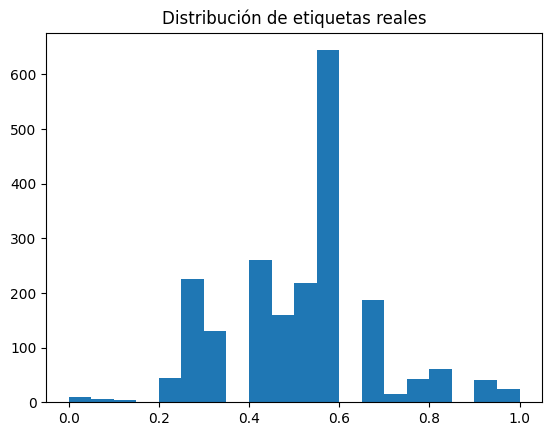

In [62]:

plt.hist(true_scores_train, bins=20)
plt.title("Distribución de etiquetas reales")
plt.show()


In [63]:
# Convertir a numpy
scores = np.array(true_scores_train)
pairs = np.array(sentence_pairs_train)

# Seleccionar ejemplos por rangos
mask_low = (scores <= 0.3)
mask_mid = (scores > 0.3) & (scores <= 0.7)
mask_high = (scores > 0.7)

# Balancear
n = min(mask_low.sum(), mask_mid.sum(), mask_high.sum())  # Tamaño mínimo de los grupos

# Tomar n ejemplos de cada grupo
balanced_pairs = np.concatenate([
    pairs[mask_low][:n],
    pairs[mask_mid][:n],
    pairs[mask_high][:n]
])
balanced_scores = np.concatenate([
    scores[mask_low][:n],
    scores[mask_mid][:n],
    scores[mask_high][:n]
])


In [ ]:
# 1. Dataset

class SimilarityDataset(Dataset):
    """
    Dataset personalizado para pares de frases y sus similitudes.
    """
    def __init__(self, pairs: List[Tuple[str, str]], similarities: List[float], tokenizer: Any, max_len: int = 128):
        self.pairs = pairs
        self.similarities = similarities
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.pairs)

    def __getitem__(self, idx: int) -> dict:
        sent1, sent2 = self.pairs[idx]
        similarity = self.similarities[idx]

        encoded1 = self.tokenizer(sent1, padding='max_length', truncation=True,
                                  max_length=self.max_len, return_tensors='pt')
        encoded2 = self.tokenizer(sent2, padding='max_length', truncation=True,
                                  max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids1': encoded1['input_ids'].squeeze(0),
            'attention_mask1': encoded1['attention_mask'].squeeze(0),
            'input_ids2': encoded2['input_ids'].squeeze(0),
            'attention_mask2': encoded2['attention_mask'].squeeze(0),
            'label': torch.tensor(similarity, dtype=torch.float)
        }

# 2. Modelo con pooling + comparación
class SimilarityModel(nn.Module):
    """
    Modelo de similitud basado en un encoder de Transformers.
    """
    def __init__(self, model_name: str):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

    def forward(self, input_ids1: torch.Tensor, attention_mask1: torch.Tensor,
                input_ids2: torch.Tensor, attention_mask2: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        out1 = self.encoder(input_ids=input_ids1, attention_mask=attention_mask1)
        out2 = self.encoder(input_ids=input_ids2, attention_mask=attention_mask2)

        # Usamos el embedding del token [CLS]
        emb1 = out1.last_hidden_state[:, 0, :]  # (batch_size, hidden_size)
        emb2 = out2.last_hidden_state[:, 0, :]

        return emb1, emb2

# 3. Función de pérdida: Cosine Similarity Loss
class CosineSimilarityLoss(nn.Module):
    """
    Función de pérdida basada en la similitud coseno y MSE.
    """
    def __init__(self):
        super().__init__()
        self.cos_sim = nn.CosineSimilarity(dim=1)
        self.mse = nn.MSELoss()

    def forward(self, emb1: torch.Tensor, emb2: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        sim = self.cos_sim(emb1, emb2)  # predicción
        loss = self.mse(sim, labels)    # MSE entre predicción y similitud real
        return loss

# Preparación de tokenizer, dataset, dataloader, modelo, función de pérdida y optimizador
tokenizer: Any = AutoTokenizer.from_pretrained('projecte-aina/roberta-base-ca-v2-cased-sts')
train_dataset: SimilarityDataset = SimilarityDataset(balanced_pairs, balanced_scores, tokenizer)
dataloader: DataLoader = DataLoader(train_dataset, batch_size=16, shuffle=True)

model: SimilarityModel = SimilarityModel('projecte-aina/roberta-base-ca-v2-cased-sts')
loss_fn: CosineSimilarityLoss = CosineSimilarityLoss()
optimizer: AdamW = AdamW(model.parameters(), lr=2e-5)


Some weights of RobertaModel were not initialized from the model checkpoint at projecte-aina/roberta-base-ca-v2-cased-sts and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Entrenamiento
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids1 = batch['input_ids1'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        labels = batch['label'].to(device)

        emb1, emb2 = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
        loss = loss_fn(emb1, emb2, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

# Guardar todo el modelo entrenado
torch.save(model.state_dict(), './modelo_entrenado3.pt')

Epoch 1 - Loss: 3.2327
Epoch 2 - Loss: 2.0414
Epoch 3 - Loss: 1.4310
Epoch 4 - Loss: 1.1652
Epoch 5 - Loss: 0.9914
Epoch 6 - Loss: 0.6520
Epoch 7 - Loss: 0.5043
Epoch 8 - Loss: 0.4765
Epoch 9 - Loss: 0.4092
Epoch 10 - Loss: 0.3856


Con 10 epoch la loss sigue siendo grande.

In [45]:
true_scores_val = [item['label']/5  for item in val]

Predecir:

In [ ]:
# 1. Obtener las similitudes predichas
model = SimilarityModel('projecte-aina/roberta-base-ca-v2-cased-sts')
model.load_state_dict(torch.load('./modelo_entrenado3.pt', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
predicciones = []
for s1, s2 in sentence_pairs_:
    encoded1 = tokenizer(s1, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    encoded2 = tokenizer(s2, return_tensors='pt', truncation=True, padding='max_length', max_length=128)

    for k in encoded1:
        encoded1[k] = encoded1[k].to(device)
        encoded2[k] = encoded2[k].to(device)

    with torch.no_grad():
        emb1, emb2 = model(
            input_ids1=encoded1['input_ids'],
            attention_mask1=encoded1['attention_mask'],
            input_ids2=encoded2['input_ids'],
            attention_mask2=encoded2['attention_mask']
        )
        sim = F.cosine_similarity(emb1, emb2).item()
        predicciones.append(sim)


Some weights of RobertaModel were not initialized from the model checkpoint at projecte-aina/roberta-base-ca-v2-cased-sts and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
correlacion, p_valor = pearsonr(predicciones, true_scores_val)
print(f"\n📈 Correlación de Pearson: {correlacion:.4f}")
print(f"📊 Valor-p: {p_valor:.4e}")


📈 Correlación de Pearson: 0.2597
📊 Valor-p: 3.7768e-09


Nos encontramos con un problema de capacidad computacional. Lo mejor sería entrenar más el modelo, para obtener mejores resultados. 